<a href="https://colab.research.google.com/github/katha815/ADME-Classifier/blob/main/Baseline_XGBoost_Model_LeaveOneChrom_OtherTesting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Baseline model
Feature groups: (1)6 phastCons scores, (2)6 phyloP scores, (3)vepDistance(?), (4){A-C,A-G,A-T,C-A,...}categorical input.

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')
import numpy as np
import pandas as pd
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import xgboost as xgb
from xgboost import XGBClassifier, plot_tree
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
from sklearn.tree import export_graphviz

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


## Leave one chromosome out Testing

In [ ]:
data2 = pd.read_csv("/content/gdrive/My Drive/Colab Notebooks/ADME Project/features.csv")
# One hot encode with get_dummies
data2 = pd.concat((data2,pd.get_dummies(data2.baseChange)),1)
print(f"Whole data: {data2}\n")
Y = data2['deleterious']
X = data2[[col for col in data2.columns if col!="pos" and col!="deleterious" and col!="ref_allele" and col!="alt_allele"and col!="baseChange"]]
print(f"X: {X}\n")
print(f"Y: {Y}\n")
grouped = X.groupby(['chrom'])
#print(grouped)

Whole data:     chrom        pos   Con4   Con7  Con17  Con20  Con30  Con100     P4     P7  \
0    chr1   46930150  0.014  0.007  0.019  0.049  0.088   0.896 -0.330 -0.821   
1    chr1   46930161  0.014  0.063  0.000  0.010  0.010   0.000 -0.854  0.061   
2    chr1   46932824  0.823  0.104  0.104  0.440  0.329   0.000 -0.280 -0.597   
3    chr1   46932987  0.982  0.962  0.078  0.962  0.996   1.000  0.606  0.917   
4    chr1   46934207  0.068  0.017  0.000  0.000  0.001   0.000  0.669 -0.328   
..    ...        ...    ...    ...    ...    ...    ...     ...    ...    ...   
332  chr8  104466712  0.998  1.000  0.989  0.999  1.000   1.000  0.714  1.039   
333  chr8  104466904  0.326  0.561  0.011  0.003  0.006   0.253  0.575  0.853   
334  chr8  142875730  0.347  0.994  0.282  0.863  0.461   1.000  0.606  0.917   
335  chr8  142879146  0.366  0.229  0.131  0.192  0.067   1.000  0.606  0.917   
336  chr9   84279999  0.806  0.923  0.812  0.976  0.988   1.000 -0.145  0.042   

     ...  3  4 

<ipython-input-18-b848402a6ca3>:3: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  data2 = pd.concat((data2,pd.get_dummies(data2.baseChange)),1)


In [ ]:
chrom_values = X['chrom'].unique()
print(f"Number of chromosome: {chrom_values.shape[0]} \n")
print(f"First split group name: {chrom_values[0]} \n")
print("First split group: \n", grouped.get_group(chrom_values[0]))

Number of chromosome: 18 

First split group name: chr1 

First split group: 
    chrom   Con4   Con7  Con17  Con20  Con30  Con100     P4     P7    P17  ...  \
0   chr1  0.014  0.007  0.019  0.049  0.088   0.896 -0.330 -0.821  0.674  ...   
1   chr1  0.014  0.063  0.000  0.010  0.010   0.000 -0.854  0.061 -4.106  ...   
2   chr1  0.823  0.104  0.104  0.440  0.329   0.000 -0.280 -0.597 -0.685  ...   
3   chr1  0.982  0.962  0.078  0.962  0.996   1.000  0.606  0.917  0.667  ...   
4   chr1  0.068  0.017  0.000  0.000  0.001   0.000  0.669 -0.328 -2.722  ...   
5   chr1  0.018  0.003  0.001  0.000  0.000   0.017  0.669  0.991 -0.152  ...   
6   chr1  0.120  0.070  0.222  0.707  0.059   0.999  0.575  0.871  0.594  ...   
7   chr1  0.212  0.636  0.067  0.142  0.042   1.000  0.714  1.062  0.756  ...   
8   chr1  0.897  0.998  0.821  0.994  0.314   1.000  0.575  0.871  0.599  ...   
9   chr1  0.084  0.055  0.289  0.387  0.664   0.816  0.669  0.079  0.665  ...   
10  chr1  0.013  0.379  0.821 

In [ ]:
print(f"Last split group name: {chrom_values[chrom_values.shape[0]-1]} \n")
print("Last split group: \n", grouped.get_group(chrom_values[chrom_values.shape[0]-1]))

Last split group name: chr9 

Last split group: 
     chrom   Con4   Con7  Con17  Con20  Con30  Con100     P4     P7    P17  \
336  chr9  0.806  0.923  0.812  0.976  0.988     1.0 -0.145  0.042  0.756   

     ...  3  4  5  6  7  8  9  10  11  12  
336  ...  0  0  0  0  0  0  0   0   0   0  

[1 rows x 34 columns]


In [ ]:
# Prepare leave one chromosome out split indexes
datasplit = []
labels = []
combined_index = [None for _ in range(chrom_values.shape[0])]
test1ist = [None for _ in range(chrom_values.shape[0])]
train1ist = [None for _ in range(chrom_values.shape[0])]

for n in range(chrom_values.shape[0]):
    chrom_i = chrom_values[n]
    new_data = grouped.get_group(chrom_i)  # Generate random data
    label = f"{chrom_i}"  # Generate label
    datasplit.append(new_data)  # Store data
    labels.append(label)  # Store label

# Print the generated data and labels
for i in range(len(labels)):
    print(f"Chromosome: {labels[i]}\n")
    print(f"Iteration: {i}\n")
    #print(f"Data: {datasplit[i]}\n")
    test1ist[i] = np.array(datasplit[i].index)
    print(f"Test indexes: {test1ist[i]}\n Label: {labels[i]}\n {type(test1ist[i])}\n")
    #*To change the line in print, use "\n" twice!
    frames = []
    for j in range(len(labels)):
      if j!=i: frames.append(datasplit[j])
    combined = pd.concat(frames)
    train1ist[i] = np.array(combined.index)
    print(f"Train indexes: {train1ist[i]}\n {type(train1ist[i])}\n")

Chromosome: chr1

Iteration: 0

Test indexes: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17]
 Label: chr1
 <class 'numpy.ndarray'>

Train indexes: [ 18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 221 222 223 224 225 

In [ ]:
X = X.drop('chrom', axis=1)
#X

In [ ]:
X = np.array([X.values.tolist()]).reshape(337,-1)
Y = np.array([Y.values.tolist()]).reshape(337,)
#print(X,Y)

In [ ]:
# Test with default XGBooster
y_true, y_pred1 = list(), list()
n = 1
for i in range(len(test1ist)):
 #print('Left chrom: ', labels[i], '\n')
 # split data
 X_train1, X_test1 = [X[i] for i in train1ist[i]], [X[i] for i in test1ist[i]]
 y_train1, y_test1 = [Y[i] for i in train1ist[i]], [Y[i] for i in test1ist[i]]
 print(f"Iteration {n}\n")
 #print('Train: ', X_train1, '\n')
 #print('Test: ', X_test1, '\n')
 # fit model
 model = XGBClassifier(objective='binary:logistic')
 model.fit(X_train1, y_train1)
 # evaluate model
 yhat = model.predict(X_test1)
 #print('True y: ', y_test1, '\n')
 #print('Estimated y: ', yhat, '\n')
 #print('Iteration accruacy: ', accuracy_score(y_test1, yhat), '\n')
 # store
 y_true.append(y_test1)
 y_pred1.append(yhat)
 n+=1
# Check results
#print('True y all: ', y_true, '\n')
#print('Estimated y all: ', y_pred1, '\n')
y_true = np.concatenate(y_true)
y_pred1 = np.concatenate(y_pred1)
print('True y all: ', y_true, '\n')
print('Estimated y all: ', y_pred1, '\n')
print('Prediction size: ', y_pred1.shape, '\n')
# calculate accuracy
acc1 = accuracy_score(y_true, y_pred1)
auc_score1 = roc_auc_score(y_true, y_pred1)
print("Model Accuray: {:.2f}%".format(100*acc1))
#97.63%
print("Model AUC_ROC: {:.4f}".format(auc_score1))
#0.9774

Iteration 1

Iteration 2

Iteration 3

Iteration 4

Iteration 5

Iteration 6

Iteration 7

Iteration 8

Iteration 9

Iteration 10

Iteration 11

Iteration 12

Iteration 13

Iteration 14

Iteration 15

Iteration 16

Iteration 17

Iteration 18

True y all:  [1 1 1 1 0 1 1 1 1 0 1 1 1 1 0 0 0 1 0 0 0 0 0 1 0 0 0 1 1 1 1 1 1 0 1 0 1
 0 1 0 0 1 1 0 1 1 1 1 1 0 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 1 0
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 1 1 0 0
 0 1 0 0 1 0 0 1 0 0 1 0 0 0 1 1 0 0 1 0 0 1 0 0 0 1 0 1 0 0 0 1 0 0 1 1 0
 1 1 0 1 0 0 1 0 0 0 1 1 0 1 1 1 1 1 1 1 1 0 0 0 1 0 0 0 0 0 1 0 1 0 0 0 1
 1 1 1 0 0 1 0 1 1 1 1 1 0 0 1 1 1 1 1 1 0 0 1 0 1 0 0 1 0 0 1 1 1 1 1 1 1
 1 1 1 1 0 0 1 1 1 0 0 1 1 0 1 1 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 1 0 1 1
 1 0 0 0 1 1 1 1 0 0 1 1 1 1 0 1 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0
 0 1 0 0 0 0 0 0 0 0 1 1 1 0 1 0 0 1 1 1 1 1 1 0 1 0 0 1 1 1 1 1 1 1 1 1 1
 0 1 1 1] 

Estimated y all:  [0 1 0 1 0 0 1 1 1 1 1 1 0 1 0 1 1 1 0 

In [ ]:
### Leave-one-chromosome-out training-testing split for randomnised dataset
## Prepare dataset
dataR = pd.read_csv("/content/gdrive/My Drive/Colab Notebooks/ADME Project/features.csv")
# One hot encode with get_dummies
dataR = pd.concat((dataR,pd.get_dummies(dataR.baseChange)),1)
Y = dataR['deleterious']
X = dataR[[col for col in dataR.columns if col!="pos" and col!="deleterious" and col!="ref_allele" and col!="alt_allele"and col!="baseChange"]]
X = X.drop('chrom', axis=1)
#print(X,'\n')
#print(Y,'\n')
X = np.array([X.values.tolist()]).reshape(337,-1)
Y = np.array([Y.values.tolist()]).reshape(337,)
#print(X,'\n')
#print(Y,'\n')
from sklearn.utils import shuffle
for m in range(10):
  print(f"Random {m}\n")
  X, Y = shuffle(X, Y, random_state=m)
## Testing for randomnised dataset
  y_true, y_pred1 = list(), list()
  n = 1
  for i in range(len(test1ist)):
 #print('Left chrom: ', labels[i], '\n')
 # split data
   X_train1, X_test1 = [X[i] for i in train1ist[i]], [X[i] for i in test1ist[i]]
   y_train1, y_test1 = [Y[i] for i in train1ist[i]], [Y[i] for i in test1ist[i]]
 #print('Train: ', train1ist[i], '\n')
 #print('Test: ', test1ist[i], '\n')
 # fit model
   model = XGBClassifier(objective='binary:logistic')
   model.fit(X_train1, y_train1)
 # evaluate model
   yhat = model.predict(X_test1)
   #print(f"Iteration {n}\n")
 #print('True y: ', y_test1, '\n')
 #print('Estimated y: ', yhat, '\n')
 #print('Iteration accruacy: ', accuracy_score(y_test1, yhat), '\n')
 # store
   y_true.append(y_test1)
   y_pred1.append(yhat)
   n+=1
# Check results
#print('True y all: ', y_true, '\n')
#print('Estimated y all: ', y_pred1, '\n')
  y_true = np.concatenate(y_true)
  y_pred1 = np.concatenate(y_pred1)
  #print('Prediction size: ', y_pred1.shape, '\n')
# calculate accuracy
  acc1 = accuracy_score(y_true, y_pred1)
  auc_score1 = roc_auc_score(y_true, y_pred1)
  print("Model Accuray: {:.2f}%".format(100*acc1))
  print("Model AUC_ROC: {:.4f}".format(auc_score1))

Random 0



<ipython-input-25-7746636eb44c>:5: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  dataR = pd.concat((dataR,pd.get_dummies(dataR.baseChange)),1)


Model Accuray: 62.91%
Model AUC_ROC: 0.6218
Random 1

Model Accuray: 62.91%
Model AUC_ROC: 0.6179
Random 2

Model Accuray: 62.02%
Model AUC_ROC: 0.6108
Random 3

Model Accuray: 64.99%
Model AUC_ROC: 0.6425
Random 4

Model Accuray: 63.20%
Model AUC_ROC: 0.6213
Random 5

Model Accuray: 60.83%
Model AUC_ROC: 0.5957
Random 6

Model Accuray: 67.06%
Model AUC_ROC: 0.6617
Random 7

Model Accuray: 64.69%
Model AUC_ROC: 0.6360
Random 8

Model Accuray: 62.61%
Model AUC_ROC: 0.6153
Random 9

Model Accuray: 62.91%
Model AUC_ROC: 0.6179


## "Comparsion of LOCO and other Testing Methods" Conclusion:
Whether select testing set from one chromosome doesn't seemt to affect the results much.
-However, mong the randomized training-testing split (average^=63%), it locates in a lowerer accuracy
range (^=61%). It verifies the assumption that LOCO is a more solid validation and omits some training/testing overlap.

In [ ]:
# Leave one chromosome out for 4 feature groups (3+3+2+1)
## Prepare dataset
data2 = pd.read_csv("/content/gdrive/My Drive/Colab Notebooks/ADME Project/features0.csv")
# One hot encode with get_dummies
data2 = pd.concat((data2,pd.get_dummies(data2.baseChange)),1)
Y = data2['deleterious']
X = data2[[col for col in data2.columns if col!="pos" and col!="deleterious" and col!="ref_allele" and col!="alt_allele"and col!="baseChange"]]
#X = X.drop('chrom', axis=1)
X = np.array([X.values.tolist()]).reshape(337,-1)
Y = np.array([Y.values.tolist()]).reshape(337,)

## Testing
y_true, y_pred1 = list(), list()
n = 1
for i in range(len(test1ist)):
 #print('Left chrom: ', labels[i], '\n')
 # split data
 X_train1, X_test1 = [X[i] for i in train1ist[i]], [X[i] for i in test1ist[i]]
 y_train1, y_test1 = [Y[i] for i in train1ist[i]], [Y[i] for i in test1ist[i]]
 #print('Train: ', X_train1, '\n')
 #print('Test: ', X_test1, '\n')
 # fit model
 model = XGBClassifier(objective='binary:logistic')
 model.fit(X_train1, y_train1)
 # evaluate model
 yhat = model.predict(X_test1)
 print(f"Iteration {n}\n")
 print('True y: ', y_test1, '\n')
 print('Estimated y: ', yhat, '\n')
 print('Iteration accruacy: ', accuracy_score(y_test1, yhat), '\n')
 # store
 y_true.append(y_test1)
 y_pred1.append(yhat)
 n+=1
# Check results
#print('True y all: ', y_true, '\n')
#print('Estimated y all: ', y_pred1, '\n')
y_true = np.concatenate(y_true)
y_pred1 = np.concatenate(y_pred1)
print('Prediction size: ', y_pred1.shape, '\n')
# calculate accuracy
acc1 = accuracy_score(y_true, y_pred1)
auc_score1 = roc_auc_score(y_true, y_pred1)
print("Model Accuray: {:.2f}%".format(100*acc1))
print("Model AUC_ROC: {:.4f}".format(auc_score1))
#Model Accuray: 61.13%
#Model AUC_ROC: 0.6021

<ipython-input-26-7b05d41dab3c>:5: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  data2 = pd.concat((data2,pd.get_dummies(data2.baseChange)),1)


Iteration 1

True y:  [1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1] 

Estimated y:  [1 1 0 1 0 0 1 1 1 1 1 1 1 1 0 0 1 1] 

Iteration accruacy:  0.7777777777777778 

Iteration 2

True y:  [0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0] 

Estimated y:  [0 1 1 1 1 0 0 1 0 1 1 1 1 0 1 0 0 0 1 1 1 0 0 1 1 0 1 1 1 1 0 0 0 1 1 0 0
 1 1 1 1 0 0 1 1 1 1 1 1 1 1 0 1 1 1 0 0 1 1 1 1 1 0 1 0 0 1 1 1 1 0 1 0 0
 1 1 1 1 0 1 0 1 1 1 0 0 1 0] 

Iteration accruacy:  0.625 

Iteration 3

True y:  [1, 1, 1, 0, 0] 

Estimated y:  [0 1 0 1 0] 

Iteration accruacy:  0.4 

Iteration 4

True y:  [0, 1] 

Estimated y:  [0 1] 

Iteration accruacy:  1.0 

Iteration 5

True y:  [0, 0, 1, 0] 

Estimated y:  [0 0 0 1] 

Iteration accruacy:  0.5 

Iteration 6

True y:  [0, 1, 0, 0, 1, 0, 0, 0,

## Finding the obest performance training-testing ratio by varyig k in K-fold testing

In [ ]:
# k-Fold testing matching the test sample size with LOCO
## Prepare dataset
data2 = pd.read_csv("/content/gdrive/My Drive/Colab Notebooks/ADME Project/features.csv")
# One hot encode with get_dummies
data2 = pd.concat((data2,pd.get_dummies(data2.baseChange)),1)
Y = data2['deleterious']
X = data2[[col for col in data2.columns if col!="pos" and col!="deleterious" and col!="ref_allele" and col!="alt_allele"and col!="baseChange"]]
X = X.drop('chrom', axis=1)
X = np.array([X.values.tolist()]).reshape(337,-1)
Y = np.array([Y.values.tolist()]).reshape(337,)

##Testing
from sklearn.model_selection import KFold

# Custom K-fold split
y_acc = []
y_AUC = []
for k in range(5,61): # 5-60 folds, meaning the testing size is about 6
  kfold = KFold(n_splits=k, shuffle=True, random_state=42)
  print(f"%Fold {k}\n")
  # Perform K-fold splitting
  y_true, y_pred1 = list(), list()
  n = 1
  for train_indexes, test_indexes in kfold.split(X):
    X_train, X_test = [X[i] for i in train_indexes], [X[i] for i in test_indexes]
    y_train, y_test = [Y[i] for i in train_indexes], [Y[i] for i in test_indexes]
    model = XGBClassifier(objective='binary:logistic')
    model.fit(X_train, y_train)
    # evaluate model
    yhat = model.predict(X_test)
    # print
    print(f"Iteration {n}\n")
    #print('True y: ', y_test, '\n')
    #print('Estimated y: ', yhat, '\n')
    print('Iteration accruacy: ', accuracy_score(y_test, yhat), '\n')
    # store
    y_true.append(y_test)
    y_pred1.append(yhat)
    n+=1
  # Check results
  #print('True y all: ', y_true, '\n')
  #print('Estimated y all: ', y_pred1, '\n')
  y_true = np.concatenate(y_true)
  y_pred1 = np.concatenate(y_pred1)
  #print('True y all: ', y_true, '\n')
  #print('Estimated y all: ', y_pred1, '\n')
  # calculate accuracy
  acc1 = accuracy_score(y_true, y_pred1)
  auc_score1 = roc_auc_score(y_true, y_pred1)
  print('Accruacy: ', acc1, '\n')
  print('AUC_ROC: ', auc_score1, '\n')
  y_acc.append(acc1)
  y_AUC.append(auc_score1)

%Fold 5



<ipython-input-27-68d3f4983c8a>:5: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  data2 = pd.concat((data2,pd.get_dummies(data2.baseChange)),1)


流式输出内容被截断，只能显示最后 5000 行内容。
Iteration accruacy:  0.5555555555555556 

Iteration 25

Iteration accruacy:  0.8888888888888888 

Iteration 26

Iteration accruacy:  0.7777777777777778 

Iteration 27

Iteration accruacy:  0.7777777777777778 

Iteration 28

Iteration accruacy:  0.6666666666666666 

Iteration 29

Iteration accruacy:  0.7777777777777778 

Iteration 30

Iteration accruacy:  0.5555555555555556 

Iteration 31

Iteration accruacy:  0.5555555555555556 

Iteration 32

Iteration accruacy:  0.6666666666666666 

Iteration 33

Iteration accruacy:  0.7777777777777778 

Iteration 34

Iteration accruacy:  0.7777777777777778 

Iteration 35

Iteration accruacy:  0.6666666666666666 

Accruacy:  0.6646884272997032 

AUC_ROC:  0.6541353383458646 

%Fold 36

Iteration 1

Iteration accruacy:  0.6 

Iteration 2

Iteration accruacy:  0.9 

Iteration 3

Iteration accruacy:  0.6 

Iteration 4

Iteration accruacy:  0.6 

Iteration 5

Iteration accruacy:  0.8 

Iteration 6

Iteration accruacy:  0.9 

It

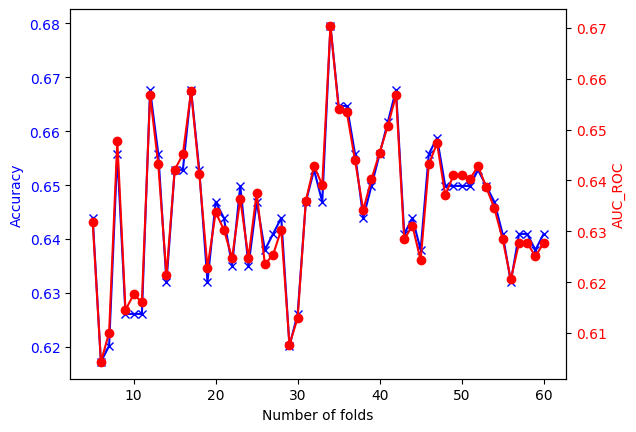

In [ ]:
fig, ax1 = plt.subplots()
ax1.plot(range(5,61), y_acc, 'bx-')
ax1.set_xlabel('Number of folds')
ax1.set_ylabel('Accuracy',color='b')
ax1.tick_params(axis='y',labelcolor='b')

ax2 = ax1.twinx()
ax2.plot(range(5,61), y_AUC, 'ro-')
ax2.set_ylabel('AUC_ROC',color='r')
ax2.tick_params(axis='y',labelcolor='r')

In [ ]:
# k-Fold testing matching the test sample size with LOCO - Shows that LOCO is more rigorous testing method
## Prepare dataset
data2 = pd.read_csv("/content/gdrive/My Drive/Colab Notebooks/ADME Project/features.csv")
Y = data2['deleterious']
X = data2[[col for col in data2.columns if col!="pos" and col!="deleterious" and col!="ref_allele" and col!="alt_allele"and col!="baseChange"]]
X = X.drop('chrom', axis=1)
X = np.array([X.values.tolist()]).reshape(337,-1)
Y = np.array([Y.values.tolist()]).reshape(337,)

##Testing
from sklearn.model_selection import KFold

# Custom K-fold split
kfold = KFold(n_splits=18, shuffle=True, random_state=42)

# Perform K-fold splitting
y_true, y_pred1 = list(), list()
n = 1
for train_indexes, test_indexes in kfold.split(X):
  X_train, X_test = [X[i] for i in train_indexes], [X[i] for i in test_indexes]
  y_train, y_test = [Y[i] for i in train_indexes], [Y[i] for i in test_indexes]
  model = XGBClassifier(objective='binary:logistic')
  model.fit(X_train, y_train)
  # evaluate model
  yhat = model.predict(X_test)
  print('True y: ', y_test, '\n')
  print('Estimated y: ', yhat, '\n')
  print(f"Iteration {n}\n")
  print('Iteration accruacy: ', accuracy_score(y_test, yhat), '\n')
  # store
  y_true.append(y_test)
  y_pred1.append(yhat)
  n+=1
# Check results
#print('True y all: ', y_true, '\n')
#print('Estimated y all: ', y_pred1, '\n')
y_true = np.concatenate(y_true)
y_pred1 = np.concatenate(y_pred1)
#print('True y all: ', y_true, '\n')
#print('Estimated y all: ', y_pred1, '\n')
print('Prediction size: ', y_pred1.shape, '\n')
# calculate accuracy
acc1 = accuracy_score(y_true, y_pred1)
auc_score1 = roc_auc_score(y_true, y_pred1)
print("Model Accuray: {:.2f}%".format(100*acc1))
print("Model AUC_ROC: {:.4f}".format(auc_score1))
#Model Accuray: 65.28%
#Model AUC_ROC: 0.6413

<ipython-input-29-d81ced2d5870>:5: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  data2 = pd.concat((data2,pd.get_dummies(data2.baseChange)),1)


True y:  [0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1] 

Estimated y:  [1 1 0 1 1 1 1 1 1 1 0 0 0 1 0 1 1 0 1] 

Iteration 1

Iteration accruacy:  0.6842105263157895 

True y:  [1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1] 

Estimated y:  [0 0 1 1 1 1 0 0 0 0 1 0 1 1 0 1 1 1 0] 

Iteration 2

Iteration accruacy:  0.5789473684210527 

True y:  [0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1] 

Estimated y:  [0 1 1 0 0 0 0 0 1 0 0 1 1 0 1 0 1 0 1] 

Iteration 3

Iteration accruacy:  0.8421052631578947 

True y:  [1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1] 

Estimated y:  [1 1 0 1 1 0 1 1 0 0 0 1 0 0 1 1 1 0 1] 

Iteration 4

Iteration accruacy:  0.5263157894736842 

True y:  [1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0] 

Estimated y:  [1 0 1 1 1 1 1 1 0 1 1 1 0 1 0 0 1 1 1] 

Iteration 5

Iteration accruacy:  0.5263157894736842 

True y:  [1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0] 

Estimated y:  [1 1 0 1 1 1 1 1 

In [ ]:
# k-Fold testing when k=4
## Prepare dataset
data2 = pd.read_csv("/content/gdrive/My Drive/Colab Notebooks/ADME Project/features.csv")
# One hot encode with get_dummies
data2 = pd.concat((data2,pd.get_dummies(data2.baseChange)),1)
Y = data2['deleterious']
X = data2[[col for col in data2.columns if col!="pos" and col!="deleterious" and col!="ref_allele" and col!="alt_allele"and col!="baseChange"]]
X = X.drop('chrom', axis=1)
X = np.array([X.values.tolist()]).reshape(337,-1)
Y = np.array([Y.values.tolist()]).reshape(337,)

##Testing
from sklearn.model_selection import KFold

# Custom K-fold split
kfold = KFold(n_splits=4, shuffle=True, random_state=42)

# Perform K-fold splitting
y_true, y_pred1 = list(), list()
n = 1
for train_indexes, test_indexes in kfold.split(X):
  X_train, X_test = [X[i] for i in train_indexes], [X[i] for i in test_indexes]
  y_train, y_test = [Y[i] for i in train_indexes], [Y[i] for i in test_indexes]
  model = XGBClassifier(objective='binary:logistic')
  model.fit(X_train, y_train)
  # evaluate model
  yhat = model.predict(X_test)
  #print('True y: ', y_test1, '\n')
  #print('Estimated y: ', yhat, '\n')
  # store
  y_true.append(y_test)
  y_pred1.append(yhat)
  # print
  print('True y: ', y_test, '\n')
  print('Estimated y: ', yhat, '\n')
  print(f"Iteration {n}\n")
  n+=1

# Check results
#print('True y all: ', y_true, '\n')
#print('Estimated y all: ', y_pred1, '\n')
y_true = np.concatenate(y_true)
y_pred1 = np.concatenate(y_pred1)
#print('True y all: ', y_true, '\n')
#print('Estimated y all: ', y_pred1, '\n')
print('Prediction size: ', y_pred1.shape, '\n')
# calculate accuracy
acc1 = accuracy_score(y_true, y_pred1)
auc_score1 = roc_auc_score(y_true, y_pred1)
print("Model Accuray: {:.2f}%".format(100*acc1))
#61.13%
print("Model AUC_ROC: {:.4f}".format(auc_score1))
#0.6014

<ipython-input-30-f46905be395c>:5: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  data2 = pd.concat((data2,pd.get_dummies(data2.baseChange)),1)


True y:  [1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1] 

Estimated y:  [1 0 1 1 1 1 0 1 0 1 1 0 1 1 0 1 0 0 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 0 1 0 1
 1 0 1 0 1 1 0 1 0 1 0 0 0 0 1 1 0 0 1 1 1 1 1 1 0 1 0 0 0 1 1 1 1 1 1 1 0
 1 1 0 1 1 0 1 1 1 0 0] 

Iteration 1

True y:  [1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1] 

Estimated y:  [1 0 0 0 1 1 1 1 1 0 0 1 1 1 0 0 1 1 1 1 1 0 1 0 1 1 1 0 1 1 0 1 0 1 1 1 1
 1 1 1 0 1 0 1 1 0 1 1 1 0 1 0 0 1 1 0 1 0 1 0 1 1 0 0 0 1 0 1 0 0 1 1 1 0
 0 0 1 0 1 1 0 1 1 1] 

Iteration 2

True y:  [1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1

In [ ]:
# k-Fold testing when k=337 -> Loop and results same with leave-one-out testing
## Prepare dataset
data2 = pd.read_csv("/content/gdrive/My Drive/Colab Notebooks/ADME Project/features.csv")
# One hot encode with get_dummies
data2 = pd.concat((data2,pd.get_dummies(data2.baseChange)),1)
Y = data2['deleterious']
X = data2[[col for col in data2.columns if col!="pos" and col!="deleterious" and col!="ref_allele" and col!="alt_allele"and col!="baseChange"]]
X = X.drop('chrom', axis=1)
X = np.array([X.values.tolist()]).reshape(337,-1)
Y = np.array([Y.values.tolist()]).reshape(337,)

##Testing
from sklearn.model_selection import KFold

# Custom K-fold split
kfold = KFold(n_splits=337, shuffle=True, random_state=42)

# Perform K-fold splitting
y_true, y_pred1 = list(), list()
n = 1
for train_indexes, test_indexes in kfold.split(X):
  X_train, X_test = [X[i] for i in train_indexes], [X[i] for i in test_indexes]
  y_train, y_test = [Y[i] for i in train_indexes], [Y[i] for i in test_indexes]
  model = XGBClassifier(objective='binary:logistic')
  model.fit(X_train, y_train)
  # evaluate model
  yhat = model.predict(X_test)
  #print('True y: ', y_test1, '\n')
  #print('Estimated y: ', yhat, '\n')
  # store
  y_true.append(y_test)
  y_pred1.append(yhat)
  # print
  print('True y: ', y_test, '\n')
  print('Estimated y: ', yhat, '\n')
  print(f"Iteration {n}\n")
  n+=1

# Check results
#print('True y all: ', y_true, '\n')
#print('Estimated y all: ', y_pred1, '\n')
y_true = np.concatenate(y_true)
y_pred1 = np.concatenate(y_pred1)
#print('True y all: ', y_true, '\n')
#print('Estimated y all: ', y_pred1, '\n')
print('Prediction size: ', y_pred1.shape, '\n')
# calculate accuracy
acc1 = accuracy_score(y_true, y_pred1)
auc_score1 = roc_auc_score(y_true, y_pred1)
print("Model Accuray: {:.2f}%".format(100*acc1))
#64.69%
print("Model AUC_ROC: {:.4f}".format(auc_score1))
#0.6337

True y:  [1] 

Estimated y:  [1] 

Iteration 1



<ipython-input-31-7a4d9e3a8a67>:5: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  data2 = pd.concat((data2,pd.get_dummies(data2.baseChange)),1)


True y:  [1] 

Estimated y:  [0] 

Iteration 2

True y:  [1] 

Estimated y:  [1] 

Iteration 3

True y:  [0] 

Estimated y:  [1] 

Iteration 4

True y:  [0] 

Estimated y:  [0] 

Iteration 5

True y:  [0] 

Estimated y:  [0] 

Iteration 6

True y:  [1] 

Estimated y:  [0] 

Iteration 7

True y:  [1] 

Estimated y:  [1] 

Iteration 8

True y:  [0] 

Estimated y:  [1] 

Iteration 9

True y:  [1] 

Estimated y:  [1] 

Iteration 10

True y:  [1] 

Estimated y:  [1] 

Iteration 11

True y:  [0] 

Estimated y:  [1] 

Iteration 12

True y:  [1] 

Estimated y:  [1] 

Iteration 13

True y:  [1] 

Estimated y:  [1] 

Iteration 14

True y:  [1] 

Estimated y:  [1] 

Iteration 15

True y:  [1] 

Estimated y:  [1] 

Iteration 16

True y:  [0] 

Estimated y:  [1] 

Iteration 17

True y:  [1] 

Estimated y:  [1] 

Iteration 18

True y:  [1] 

Estimated y:  [1] 

Iteration 19

True y:  [1] 

Estimated y:  [1] 

Iteration 20

True y:  [1] 

Estimated y:  [1] 

Iteration 21

True y:  [1] 

Estimated y: 

In [ ]:
# Leave one sample out
## Prepare dataset
data2 = pd.read_csv("/content/gdrive/My Drive/Colab Notebooks/ADME Project/features.csv")
# One hot encode with get_dummies
data2 = pd.concat((data2,pd.get_dummies(data2.baseChange)),1)
Y = data2['deleterious']
X = data2[[col for col in data2.columns if col!="pos" and col!="deleterious" and col!="ref_allele" and col!="alt_allele"and col!="baseChange"]]
X = X.drop('chrom', axis=1)
X = np.array([X.values.tolist()]).reshape(337,-1)
Y = np.array([Y.values.tolist()]).reshape(337,)

## Testing
from sklearn.model_selection import LeaveOneOut
#define cross-validation method to use
cv = LeaveOneOut()
# enumerate splits
y_true, y_predLOO = list(), list()
n = 1
for train_ix, test_ix in cv.split(X):
 # split data
 X_train1, X_test1 = X[train_ix], X[test_ix]
 y_train1, y_test1 = Y[train_ix], Y[test_ix]
 # fit model
 model = XGBClassifier(objective='binary:logistic')
 model.fit(X_train1, y_train1)
 # evaluate model
 yhat = model.predict(X_test1)
 # store
 y_true.append(y_test1)
 y_predLOO.append(yhat)
 # print
 print('True y: ', y_test1, '\n')
 print('Estimated y: ', yhat, '\n')
 print(f"Iteration {n}\n")
 n+=1

# Check results
y_true = np.concatenate(y_true)
y_predLOO = np.concatenate(y_predLOO)
print('True y all: ', y_true, '\n')
print('Estimated y all: ', y_predLOO, '\n')
print('Prediction size: ', y_predLOO.shape, '\n')

# Calculate accuracy
acc = accuracy_score(y_true, y_predLOO)
auc_score = roc_auc_score(y_true, y_predLOO)
print("Model Accuray: {:.2f}%".format(100*acc))
#64.69%
print("Model AUC_ROC: {:.4f}".format(auc_score))
#0.6337

True y:  [1] 

Estimated y:  [1] 

Iteration 1



<ipython-input-32-28f88ca5399a>:5: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  data2 = pd.concat((data2,pd.get_dummies(data2.baseChange)),1)


True y:  [1] 

Estimated y:  [1] 

Iteration 2

True y:  [1] 

Estimated y:  [1] 

Iteration 3

True y:  [1] 

Estimated y:  [1] 

Iteration 4

True y:  [0] 

Estimated y:  [0] 

Iteration 5

True y:  [1] 

Estimated y:  [0] 

Iteration 6

True y:  [1] 

Estimated y:  [1] 

Iteration 7

True y:  [1] 

Estimated y:  [1] 

Iteration 8

True y:  [1] 

Estimated y:  [1] 

Iteration 9

True y:  [0] 

Estimated y:  [1] 

Iteration 10

True y:  [1] 

Estimated y:  [1] 

Iteration 11

True y:  [1] 

Estimated y:  [1] 

Iteration 12

True y:  [1] 

Estimated y:  [1] 

Iteration 13

True y:  [1] 

Estimated y:  [1] 

Iteration 14

True y:  [0] 

Estimated y:  [0] 

Iteration 15

True y:  [0] 

Estimated y:  [0] 

Iteration 16

True y:  [0] 

Estimated y:  [1] 

Iteration 17

True y:  [1] 

Estimated y:  [1] 

Iteration 18

True y:  [0] 

Estimated y:  [0] 

Iteration 19

True y:  [0] 

Estimated y:  [1] 

Iteration 20

True y:  [0] 

Estimated y:  [1] 

Iteration 21

True y:  [0] 

Estimated y: 

In [ ]:
# Check indexes for leave one sample out
from sklearn.model_selection import LeaveOneOut
cv = LeaveOneOut()
# enumerate splits
y_true, y_pred1 = list(), list()
n = 1
for train_ix, test_ix in cv.split(X):
  print(f"Iteration {n} \n")
  print(f"Test indexes: {test_ix} \n")
  print(f"Train indexes: {train_ix} \n")
  n+=1

流式输出内容被截断，只能显示最后 5000 行内容。
 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234
 235 236 237 238 239 240 241 242 243 244 245 246 247 248 249 250 251 252
 253 254 255 256 257 258 259 260 261 262 263 264 265 266 267 268 269 270
 271 272 273 274 275 276 277 278 279 280 281 282 283 284 285 286 287 288
 289 290 291 292 293 294 295 296 297 298 299 300 301 302 303 304 305 306
 307 308 309 310 311 312 313 314 315 316 317 318 319 320 321 322 323 324
 325 326 327 328 329 330 331 332 333 334 335 336] 

Iteration 130 

Test indexes: [129] 

Train indexes: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 